In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import numpy as np
import os

from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# this note book is six-class image classfication for solar panels
# below is some comments for this note book
1. metrics
   this notebook uses 8 metrics: Accuracy、Precision、Recall、F1-Score、Specificity、ROC-AUC、Top-k Accuracy、Logarithmic Loss (Log Loss)      and confusion matrix
2. model
   The model will combine:(1)Residual Learning:Add skip connections to mitigate vanishing gradients.(2)Inception Module:Use filters of       varying sizes (1x1, 3x3, 5x5) and a bottleneck strategy to reduce parameters.(3)Depthwise Separable Convolutions:Efficient convolution    operations to reduce computational load.(4)Attention Mechanism:Implement a channel attention mechanism like Squeeze-and-Excitation        (SE) blocks.
3. XAI
   this notebook uses GradCAM for XAI
   

# 1. Load the data

In [15]:
image_directory = '/kaggle/input/solar-panel-images/Faulty_solar_panel'

# Create a training dataset from the directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,  # Split the data into a training and validation set
    subset='training', # Using 'training' to create a training dataset
    shuffle=True,
    seed=42 
)

# Create a testing (validation) dataset from the same directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,  # Split the data into a training and validation set
    subset='validation', # Using  'validation' to create a testing (validation) dataset
    shuffle=True,
    seed=42
)



Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


# 2. show the lables

In [40]:

lables

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

## 3. Plotting the images along with labels and seeing how it looks like 

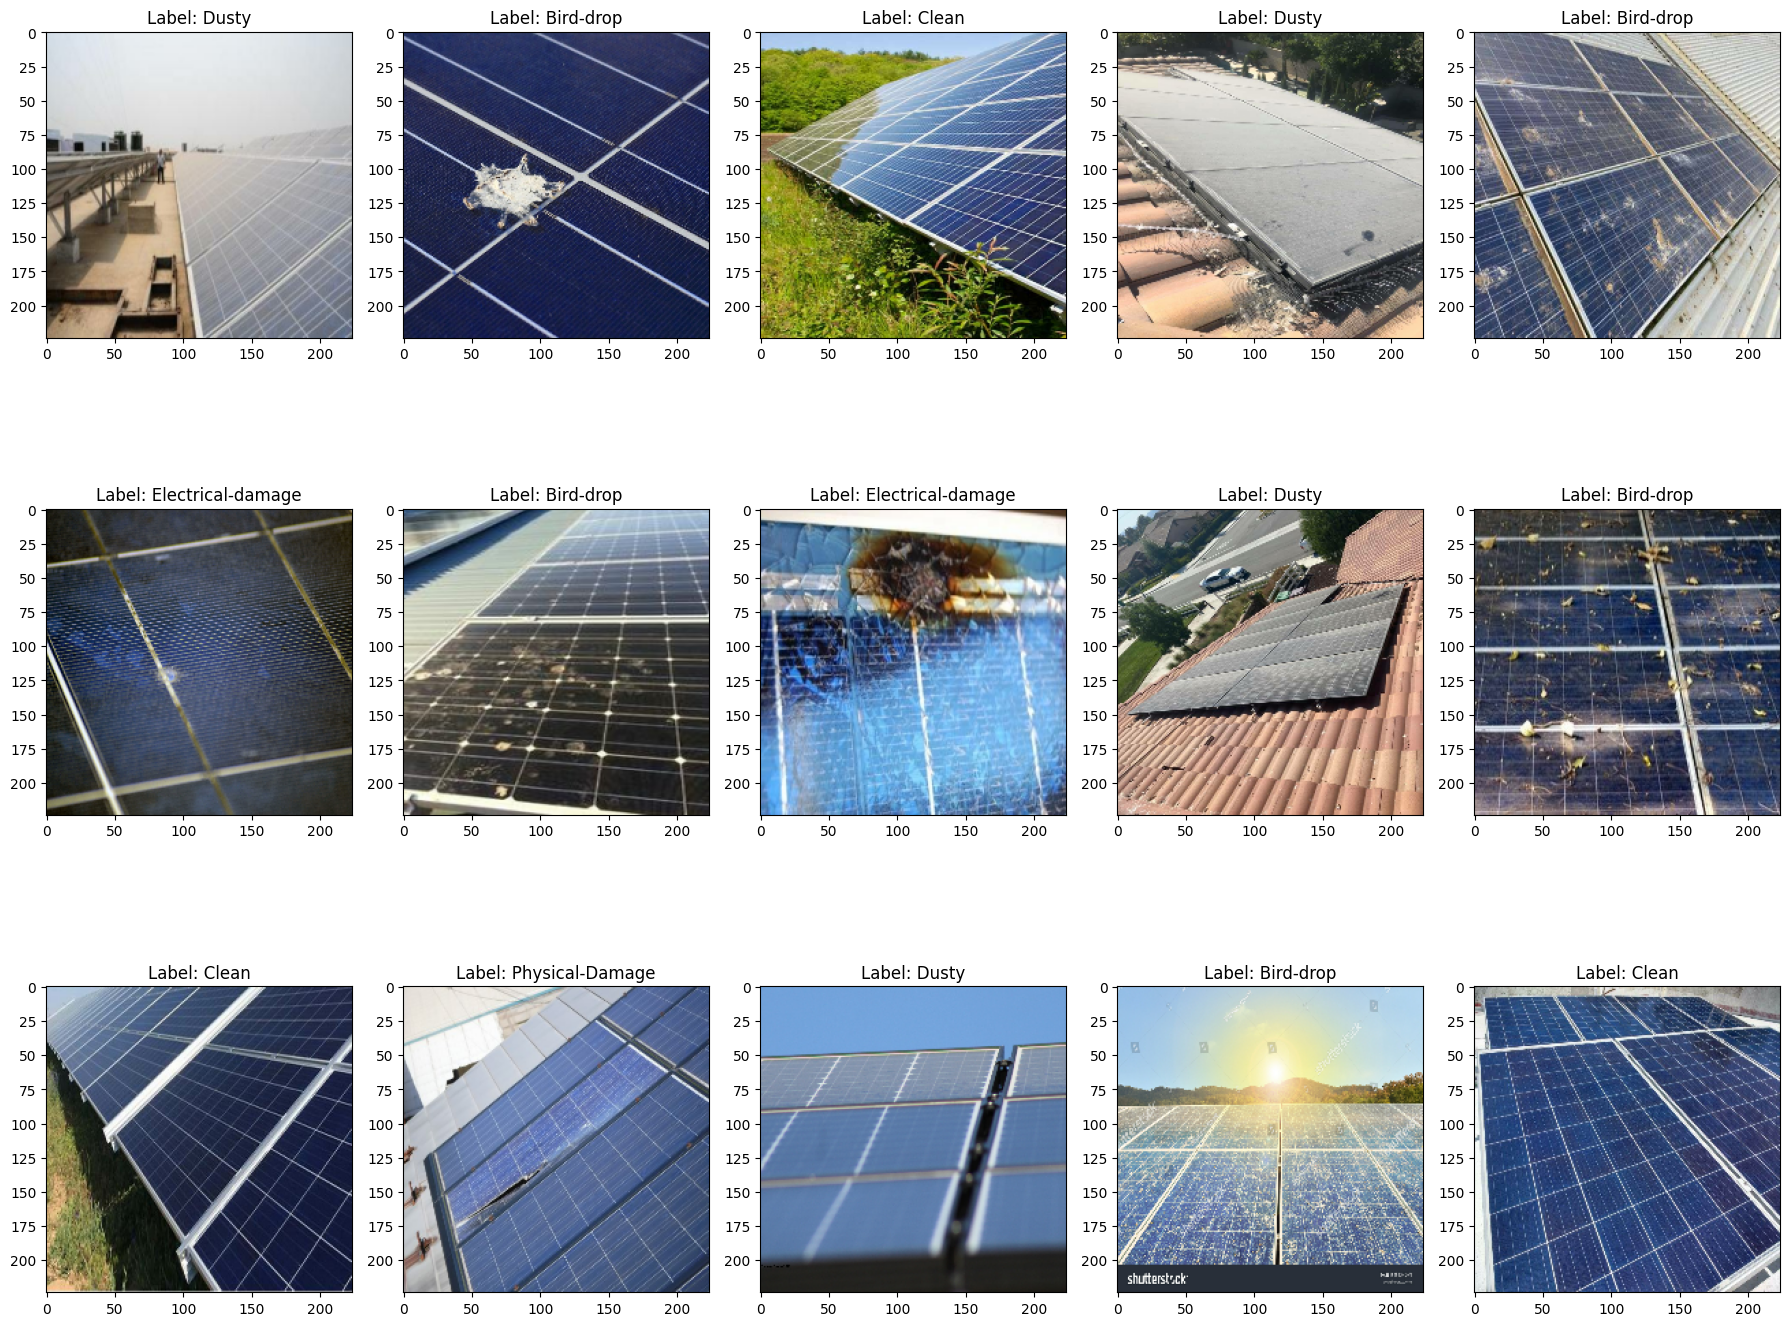

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,15))

num_samples_to_display = 15
for images, labels in train_dataset.take(2):  # Only taking one batch from the training dataset
    for i in range(num_samples_to_display):
        image = images[i].numpy().astype("uint8") 
        label = labels[i]
        
        # Create a subplot
        plt.subplot(3, 5, i + 1)
        plt.imshow(image)  
        plt.title(f'Label: {lables[label]}') ## lables which is defined earlier has been used to call images labels

plt.tight_layout()  
plt.show() 


# 4. define the model

In [18]:
# residual block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    return ReLU()(x)

# inception block
def inception_block(x, filters):
    # Branch 1: 1x1 Conv
    branch1 = Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    
    # Branch 2: 1x1 Conv -> 3x3 Conv
    branch2 = Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    branch2 = Conv2D(filters, (3, 3), padding="same", activation="relu")(branch2)
    
    # Branch 3: 1x1 Conv -> 5x5 Conv
    branch3 = Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    branch3 = Conv2D(filters, (5, 5), padding="same", activation="relu")(branch3)
    
    # Concatenate
    return tf.keras.layers.Concatenate()([branch1, branch2, branch3])

# attention block
def attention_module(x):
    # Determine the number of filters dynamically
    filters = x.shape[-1]  # Extract the channel dimension
    
    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(x)  # Output shape: (batch_size, filters)
    se = Dense(filters // 16, activation="relu")(se)  # Bottleneck
    se = Dense(filters, activation="sigmoid")(se)  # Output shape: (batch_size, filters)
    
    # Reshape to match x's shape
    se = tf.keras.layers.Reshape((1, 1, filters))(se)  # Output shape: (batch_size, 1, 1, filters)
    
    # Scale: Element-wise multiplication
    return tf.keras.layers.Multiply()([x, se])

# the self-define model
def custom_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    
    # Residual Block
    x = residual_block(x, 32)
    
    # Inception Block
    x = inception_block(x, 64)
    
    # Depthwise Separable Convolution
    x = DepthwiseConv2D((3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    
    # Attention Module
    x = attention_module(x)

    
    # Classification Head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs, outputs)


# one-hot code lables

In [21]:
# one hot code the lables
def preprocess_labels(image, label):
    # Assuming num_classes = 6
    label = tf.one_hot(label, depth=6)
    return image, label

train_dataset = train_dataset.map(preprocess_labels)
test_dataset = test_dataset.map(preprocess_labels)

# 5. conpile the model

In [23]:
from tensorflow.keras.metrics import AUC, TopKCategoricalAccuracy, Precision, Recall


In [24]:
model = custom_model(input_shape=(224, 224, 3), num_classes=6)

In [25]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(name="precision"), 
        Recall(name="recall"), 
        tf.keras.metrics.SpecificityAtSensitivity(0.5, name="specificity"),
        tf.keras.metrics.SensitivityAtSpecificity(0.5, name="sensitivity"),
        AUC(name="roc_auc"),
        TopKCategoricalAccuracy(k=3, name="top_3_accuracy"),
    ]
)

In [37]:
# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 224, 224, 32  128        ['conv2d_16[0][0]']              
 rmalization)                   )                                                           

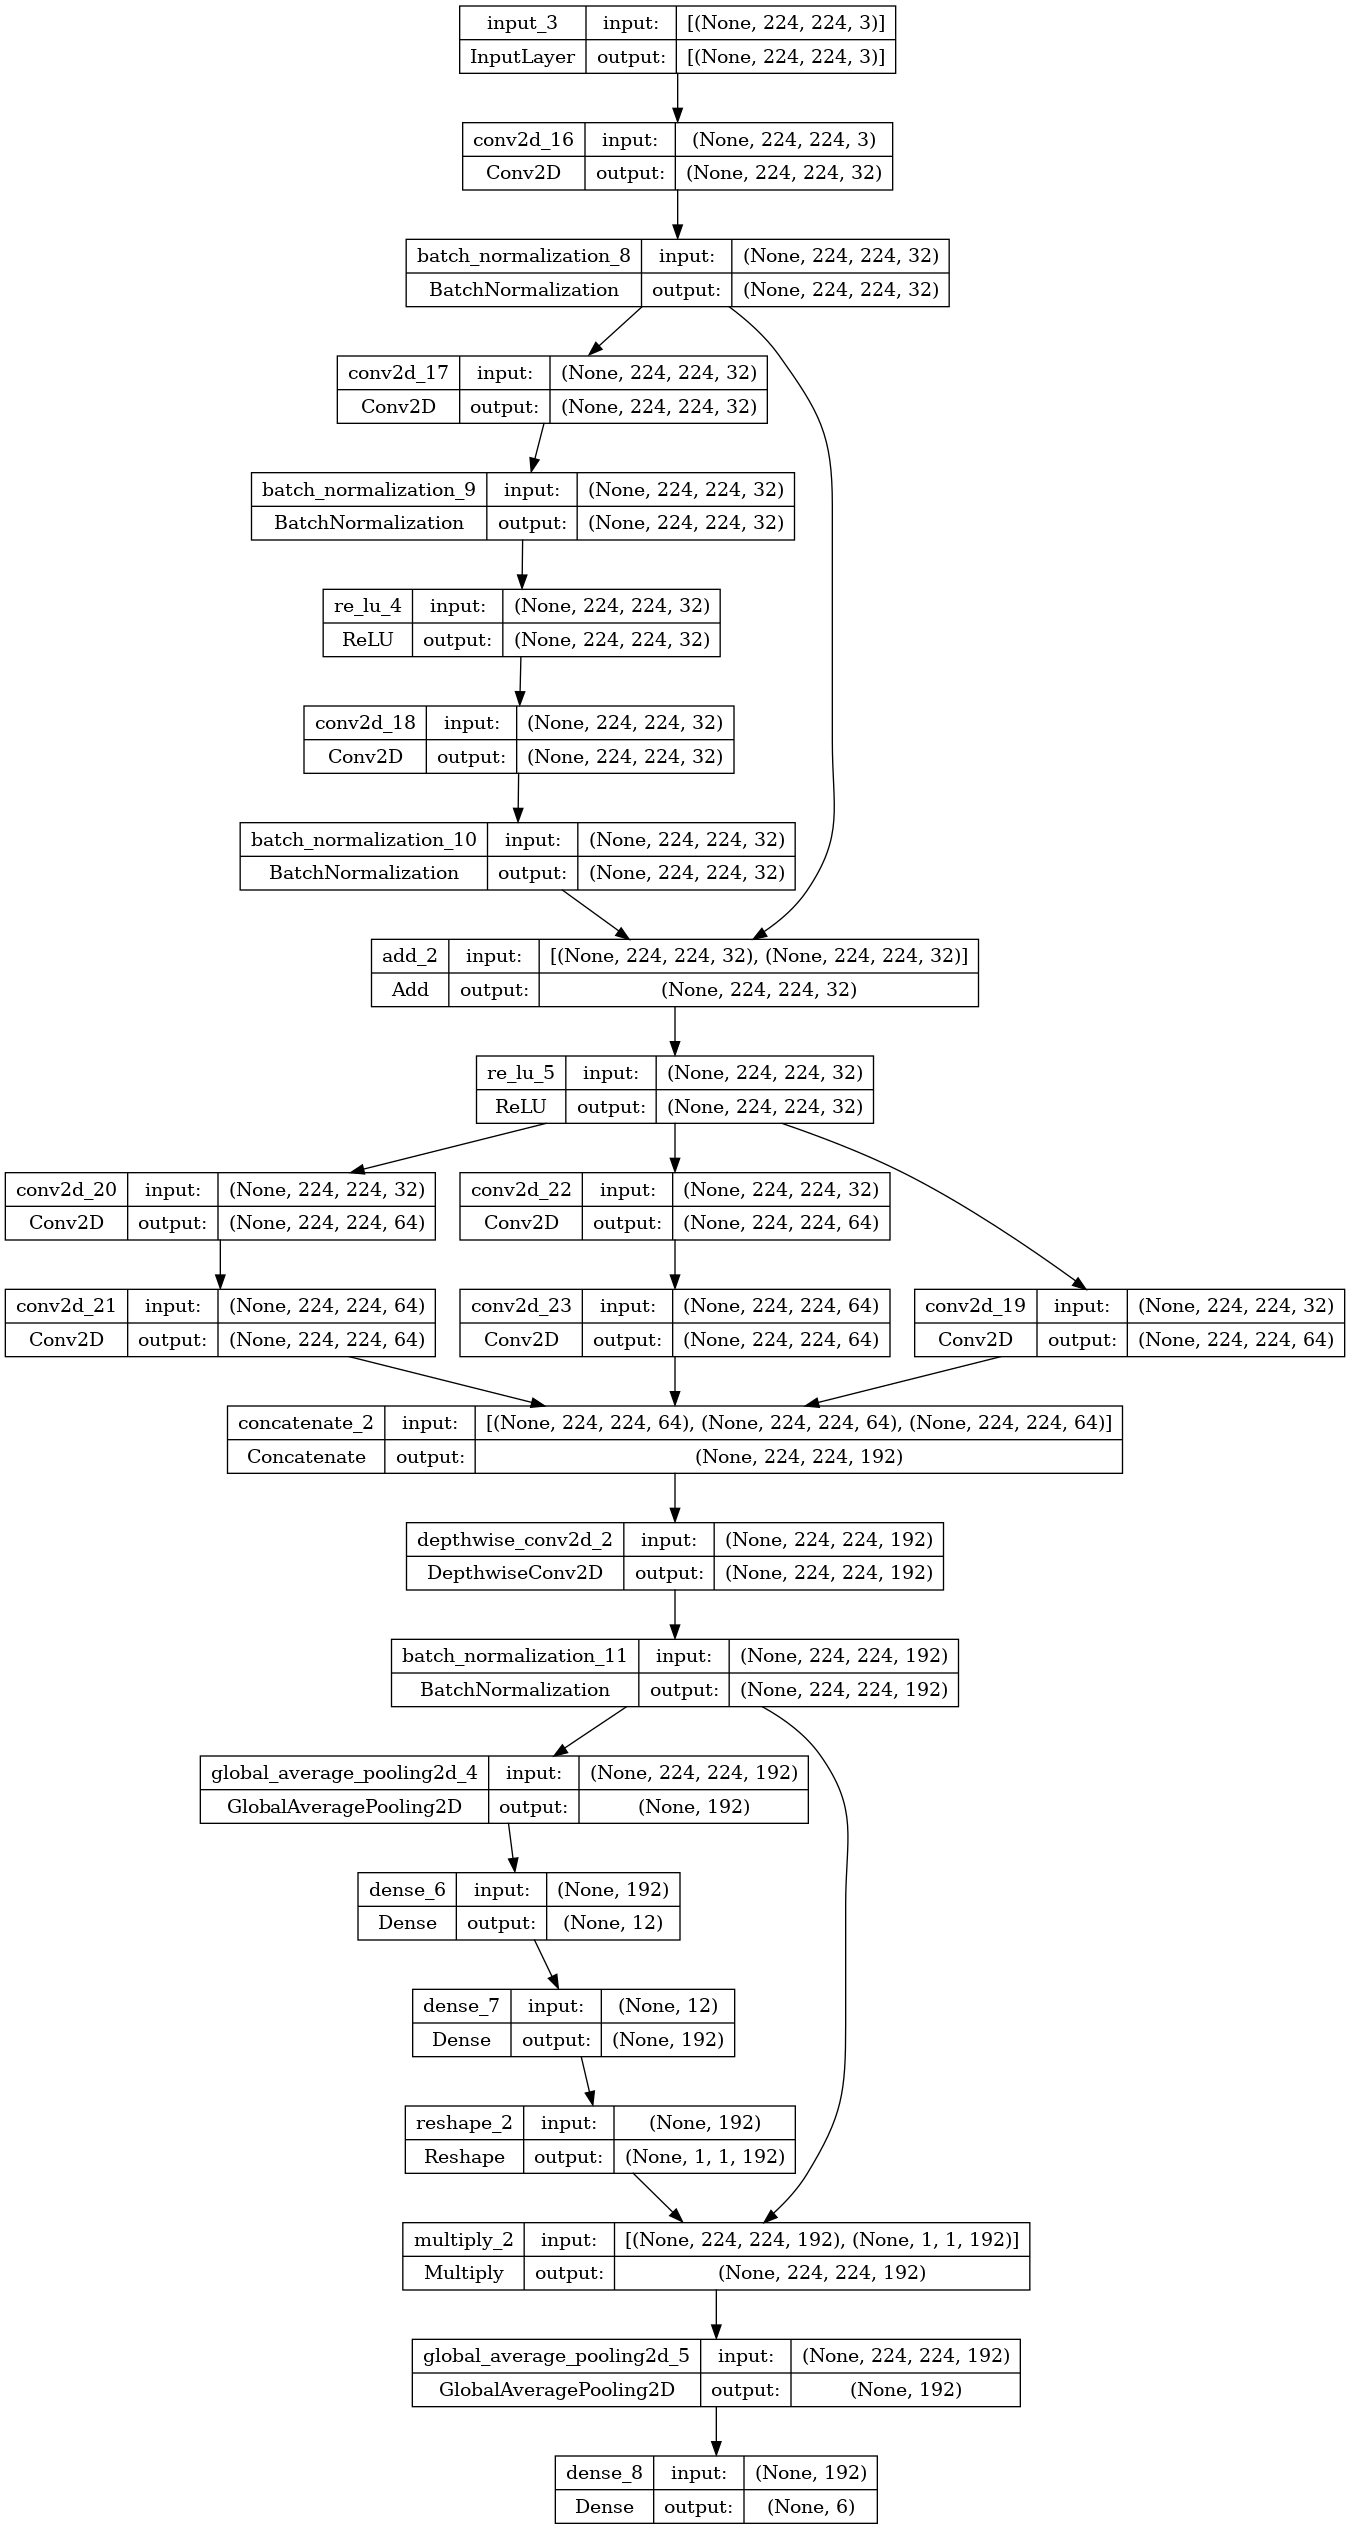

In [38]:
from tensorflow.keras.utils import plot_model

# Directly display the model structure
plot_model(model, show_shapes=True, show_layer_names=True)

# 6. train and evaluate the model

In [26]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20, batch_size=32
)


Epoch 1/20
23/23 [==============================] - 48s 1s/step - loss: 1.5033 - accuracy: 0.4619 - precision: 0.7639 - recall: 0.0777 - specificity: 0.8709 - sensitivity: 0.8503 - roc_auc: 0.7860 - top_3_accuracy: 0.8008 - val_loss: 2.3318 - val_accuracy: 0.1186 - val_precision: 0.1638 - val_recall: 0.1073 - val_specificity: 0.3898 - val_sensitivity: 0.4407 - val_roc_auc: 0.4964 - val_top_3_accuracy: 0.4237
Epoch 2/20
23/23 [==============================] - 25s 987ms/step - loss: 1.2440 - accuracy: 0.5607 - precision: 0.7477 - recall: 0.2302 - specificity: 0.9362 - sensitivity: 0.9195 - roc_auc: 0.8525 - top_3_accuracy: 0.8672 - val_loss: 1.8926 - val_accuracy: 0.1977 - val_precision: 0.6000 - val_recall: 0.0847 - val_specificity: 0.4960 - val_sensitivity: 0.4802 - val_roc_auc: 0.5573 - val_top_3_accuracy: 0.4802
Epoch 3/20
23/23 [==============================] - 24s 953ms/step - loss: 1.1665 - accuracy: 0.5862 - precision: 0.7166 - recall: 0.3178 - specificity: 0.9460 - sensitivity

In [27]:
results = model.evaluate(test_dataset)
for metric, value in zip(model.metrics_names, results):
    print(f"{metric}: {value:.4f}")


6/6 [==============================] - 3s 199ms/step - loss: 1.0970 - accuracy: 0.5819 - precision: 0.6484 - recall: 0.4689 - specificity: 0.9390 - sensitivity: 0.9661 - roc_auc: 0.8824 - top_3_accuracy: 0.8983
loss: 1.0970
accuracy: 0.5819
precision: 0.6484
recall: 0.4689
specificity: 0.9390
sensitivity: 0.9661
roc_auc: 0.8824
top_3_accuracy: 0.8983


# 7, show the confusion matrix

1/1 [==============================] - 0s 24ms/step


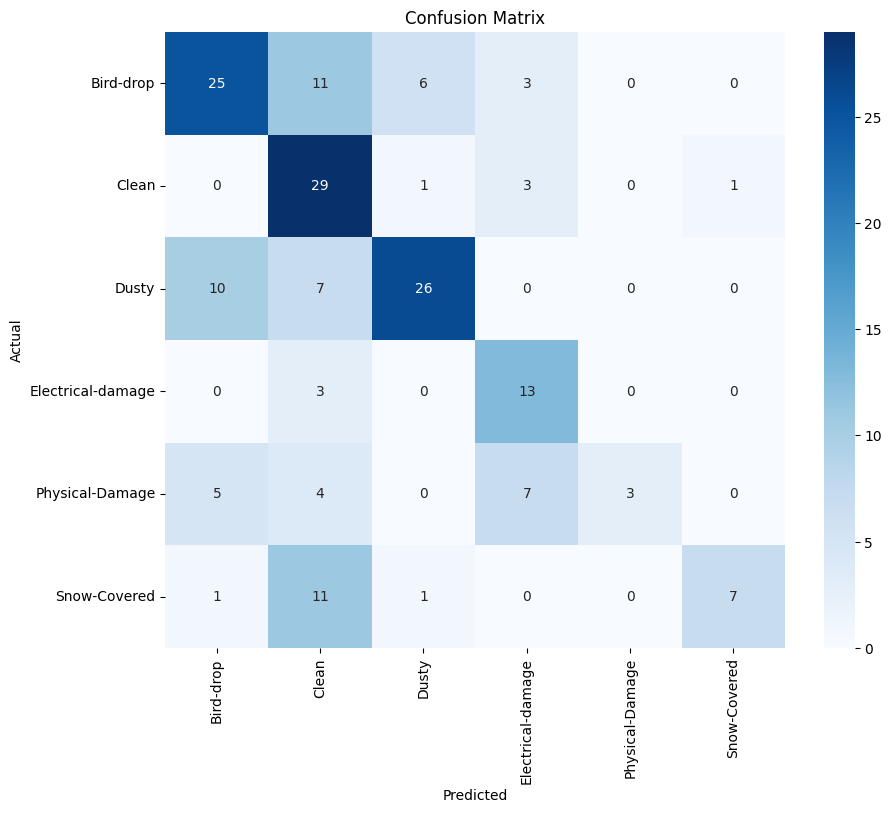

                   precision    recall  f1-score   support

        Bird-drop       0.61      0.56      0.58        45
            Clean       0.45      0.85      0.59        34
            Dusty       0.76      0.60      0.68        43
Electrical-damage       0.50      0.81      0.62        16
  Physical-Damage       1.00      0.16      0.27        19
     Snow-Covered       0.88      0.35      0.50        20

         accuracy                           0.58       177
        macro avg       0.70      0.56      0.54       177
     weighted avg       0.68      0.58      0.57       177



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Get class names from the directory structure
class_names = sorted(os.listdir(image_directory))  # Assuming that image_directory contains subfolders as classes

# Predict classes
y_true_classes = []  # Store true labels
y_pred_classes = []  # Store predicted labels

# Iterate through the test dataset and collect predictions
for images, labels in test_dataset:
    # Predict on the batch
    y_pred = model.predict(images)
    y_pred_classes_batch = tf.argmax(y_pred, axis=1).numpy()  # Convert to numpy array
    
    # Get the true labels (they are already in integer format)
    y_true_classes_batch = tf.argmax(labels, axis=1).numpy()  # One-hot to integer
    
    # Append the batch results
    y_true_classes.extend(y_true_classes_batch)
    y_pred_classes.extend(y_pred_classes_batch)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


# 8. show the Logarithmic Loss

In [33]:
from sklearn.metrics import log_loss
import numpy as np

# Initialize lists to collect true labels and predicted probabilities
y_true_all = []  # True labels (in one-hot format)
y_pred_all = []  # Predicted probabilities

# Iterate through the test dataset and collect predictions
for images, labels in test_dataset:
    # Predict on the batch
    y_pred = model.predict(images)
    
    # Append the true labels (one-hot) and predicted probabilities
    y_true_all.append(labels.numpy())  # Convert to numpy
    y_pred_all.append(y_pred)  # Predicted probabilities (softmax outputs)

# Concatenate all batches
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

# Calculate log loss
logloss = log_loss(y_true_all, y_pred_all)
print(f"Log Loss: {logloss:.4f}")

1/1 [==============================] - 0s 30ms/step
Log Loss: 1.0970


# 9. show the metrics

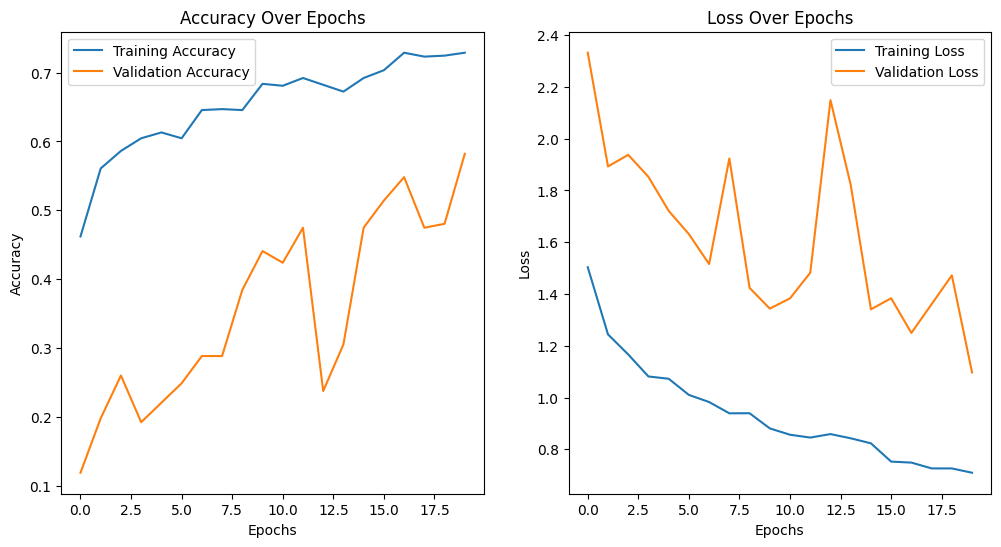

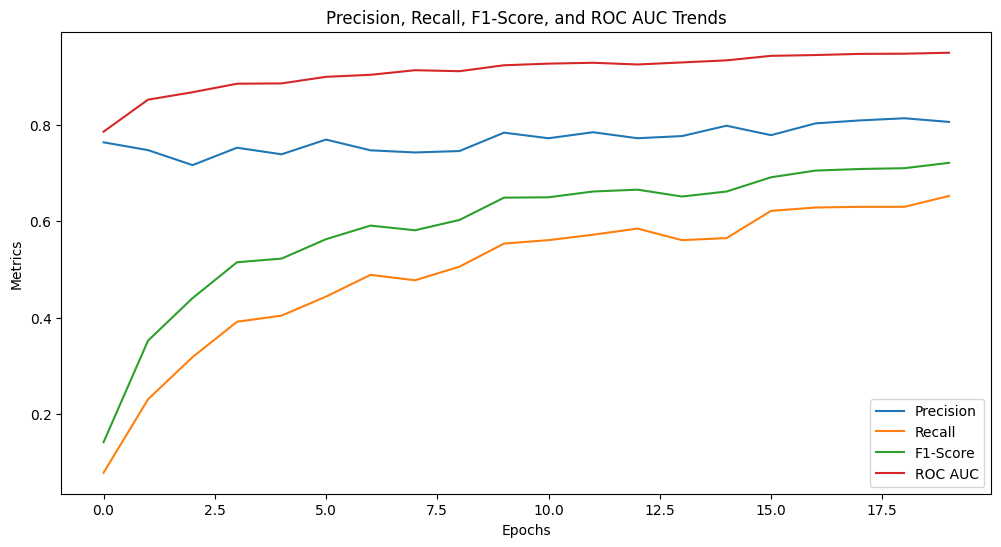

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Plot precision, recall, F1-score, and ROC AUC trends
plt.figure(figsize=(12, 6))

# Plot precision
plt.plot(history.history["precision"], label="Precision")

# Plot recall
plt.plot(history.history["recall"], label="Recall")

# Correct F1-score calculation (ensure parentheses are properly closed)
f1_score = 2 * np.array(history.history["precision"]) * np.array(history.history["recall"]) / (
    np.array(history.history["precision"]) + np.array(history.history["recall"]) + 1e-7
)
plt.plot(f1_score, label="F1-Score")

# Plot ROC AUC
plt.plot(history.history["roc_auc"], label="ROC AUC")

# Title, labels, and legend
plt.title("Precision, Recall, F1-Score, and ROC AUC Trends")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()

plt.show()


# 10. the XAI, the heat map for predicating one image

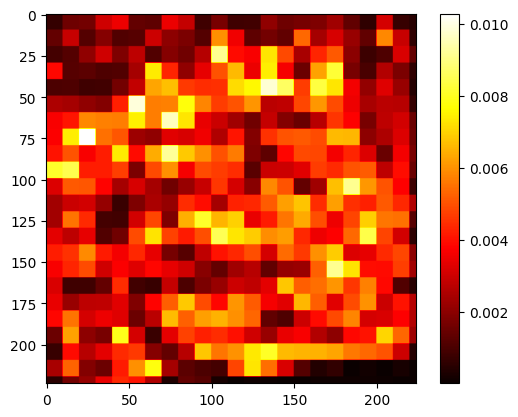

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to compute Occlusion Sensitivity
def occlusion_sensitivity(model, image, patch_size=10):
    # Get the original prediction probabilities
    original_pred = model(image)
    
    # Initialize sensitivity map (same size as input image, excluding batch dimension)
    sensitivity_map = np.zeros((image.shape[1], image.shape[2]))

    # Loop over the image in patches
    for i in range(0, image.shape[1], patch_size):
        for j in range(0, image.shape[2], patch_size):
            # Occlude the patch by setting it to 0
            occluded_image = np.copy(image)
            occluded_image[0, i:i + patch_size, j:j + patch_size, :] = 0  # Occlude the patch

            # Get prediction probabilities for the occluded image
            pred = model(occluded_image)
            
            # Calculate the difference in class probability (sensitivity)
            sensitivity_map[i:i + patch_size, j:j + patch_size] = np.sum(np.abs(original_pred - pred), axis=-1)

    return sensitivity_map




# Get a batch of image data
image = test_dataset.take(10)  # Modify this based on your data
image = next(iter(image))[0]  # Convert to batch of images
image = image[0][tf.newaxis, ...]  # Select the first image in the batch


# Get occlusion sensitivity map
occlusion_map = occlusion_sensitivity(model, image)

# Plot the occlusion sensitivity map
plt.imshow(occlusion_map, cmap='hot')
plt.colorbar()
plt.show()

